## Possible investigations
1. fraud score correlation
  - Investigate if there's a correlation between fraud score and user details e.g.,
    - IP address characteristics (e.g., country, VPN usage, proxy usage).
    - Email details (e.g., presence on breach databases, domain reputation).
    - Phone validity and carrier.

  - Cross-referencing IP, email, and phone data: If a user is accessing multiple services (as seen in their account details), we can investigate the consistency between IP and device types

2. Investigate patterns
- Account activity (e.g., very few registered accounts across platforms)
- Service registration patterns (registering on certain services but not others)
- Phone & email patterns (disposable/funky phones, non-existent emails?)



In [ ]:
#importing all (potentially) useful libraries and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from pandas.api.types import is_integer_dtype, is_float_dtype, is_string_dtype

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#loading the dataset

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/transactions_cleaned.csv")

# Data Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/My Drive/transactions_cleaned.csv')

target = df['is_disputed']
df = df.drop(columns=['is_disputed', 'Unnamed: 0'])
df.insert(0, 'is_disputed', target)
df.head()

,is_disputed,data.ip_details.type,data.device_details.battery_level,success,data.email_details.history.last_seen,data.email_details.account_details.xing.registered,data.phone_details.history.customer_hits,data.device_details.plugin_hash,data.email_details.domain_details.disposable,data.email_details.account_details.discord.registered,...,data.phone_details.type,data.ip_details.history.last_seen,data.email_details.account_details.microsoft.registered,data.email_details.account_details.twitter.registered,phone_details.account_details.facebook.registered,phone_details.type,data.email_details.account_details.imgur.registered,data.email_details.account_details.apple.registered,data.email_details.account_details.tiki.registered,data.device_details.screen_color_depth
0,False,ISP,100.0,True,1727230489,False,2,NaN,False,False,...,mobile,1727230489,True,False,True,mobile,False,False,False,24.0
1,False,MOB,60.0,True,1719107642,NaN,1,29b51cf1619fb6943f256c2c6da59432,False,False,...,mobile,1719107640,True,False,True,mobile,False,False,False,24.0
2,False,MOB,60.0,True,1640278985,False,1,29b51cf1619fb6943f256c2c6da59432,False,False,...,mobile,1721881459,True,False,True,mobile,False,True,False,24.0
3,False,ISP/MOB,80.0,True,1697310426,False,1,NaN,False,False,...,mobile,1729553573,True,False,True,mobile,NaN,False,False,24.0
4,False,MOB,28.0,True,1721592648,False,1,NaN,False,False,...,mobile,1721592646,False,False,True,mobile,False,False,False,24.0


In [ ]:
print(df.shape)

(15513, 215)


All of the 15513 transactions are successful, so we can drop the 'success' column. Among these successful transactions, 513 are disputed.

In [ ]:
not_success_count = df[(df['success'] == False)].shape[0]
print(not_success_count)

0


In [ ]:
false_disputed_success_true = df[(df['is_disputed'] == False) & (df['success'] == True)].shape[0]

true_disputed_success_false = df[(df['is_disputed'] == True) & (df['success'] == False)].shape[0]

true_disputed_success_true = df[(df['is_disputed'] == True) & (df['success'] == True)].shape[0]


print(f"Rows with 'is_disputed' as False and 'success' as True: {false_disputed_success_true}")
print(f"Rows with 'is_disputed' as True and 'success' as False: {true_disputed_success_false}")
print(f"Success but disputed: {true_disputed_success_true}")

Rows with 'is_disputed' as False and 'success' as True: 15000
Rows with 'is_disputed' as True and 'success' as False: 0
Success but disputed: 513


In [ ]:
df.drop(columns=['success'], errors='ignore', inplace=True)

Confusion Matrix for result vs is_disputed

In [ ]:
result = df['result']
df.drop(columns=['result'], errors='ignore', inplace=True)
df.insert(1, 'result', result)

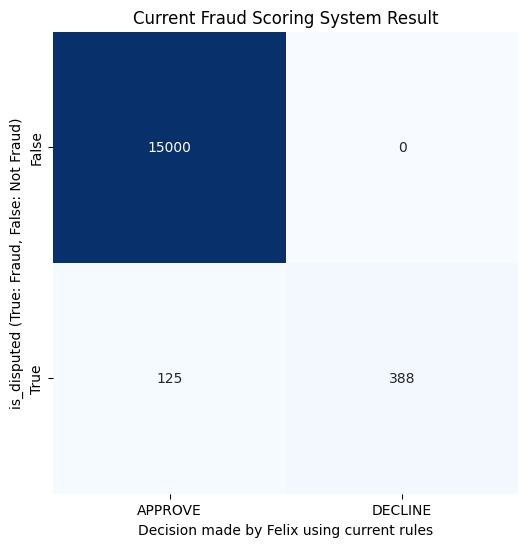

In [ ]:
# Create a 2x2 matrix (contingency table)
contingency_table = pd.crosstab(df['is_disputed'], df['result'])

# Plot the matrix
plt.figure(figsize=(6, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Current Fraud Scoring System Result")
plt.xlabel("Decision made by Felix using current rules")
plt.ylabel("is_disputed (True: Fraud, False: Not Fraud)")
plt.show()

Datatype of the features

In [ ]:
column_types = df.dtypes

# Count the number of columns for each data type
type_counts = column_types.value_counts()

# Print the results
for dtype, count in type_counts.items():
    print(f"{dtype}: {count} columns")

object: 150 columns
bool: 27 columns
int64: 25 columns
float64: 12 columns


In [ ]:
df.describe()

,data.device_details.battery_level,data.email_details.history.last_seen,data.phone_details.history.customer_hits,phone_details.history.customer_hits,data.device_details.hardware_concurrency,phone_details.history.last_seen,data.phone_details.history.first_seen,amount,data.email_details.history.hits,data.ip_details.history.first_seen,...,data.ip_details.history.hits,data.device_details.webrtc_count,data.phone_details.history.hits,data.device_details.font_count,phone_details.history.hits,phone_details.score,data.device_details.device_memory,data.ip_details.spam_number,data.ip_details.history.last_seen,data.device_details.screen_color_depth
count,15513.000000,1.551300e+04,15513.000000,15513.000000,15513.000000,1.551300e+04,1.551300e+04,15513.000000,15513.000000,1.551300e+04,...,15513.000000,15513.000000,15513.000000,15513.000000,15513.000000,15513.0,15513.000000,15513.000000,1.551300e+04,15513.000000
mean,59.167086,1.720235e+09,1.037130,1.037130,5.774705,1.723317e+09,1.723235e+09,359.134695,2.114678,1.706552e+09,...,101.320441,2.557210,1.048089,19.574228,1.048089,0.0,4.598079,0.077161,1.723196e+09,24.400954
std,16.514147,1.532405e+07,0.217025,0.217025,2.018347,6.741177e+06,7.062041e+06,408.636726,6.518594,3.232223e+07,...,374.161525,0.857402,0.317746,4.291941,0.317746,0.0,1.602542,0.329157,6.842751e+06,1.739814
min,1.000000,1.581445e+09,1.000000,1.000000,2.000000,1.655283e+09,1.655283e+09,0.000000,1.000000,1.573694e+09,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.590372e+09,24.000000
25%,60.000000,1.719438e+09,1.000000,1.000000,4.000000,1.720233e+09,1.720228e+09,80.000000,1.000000,1.700182e+09,...,1.000000,2.000000,1.000000,16.000000,1.000000,0.0,4.000000,0.000000,1.720068e+09,24.000000
50%,60.000000,1.723352e+09,1.000000,1.000000,4.000000,1.724057e+09,1.724043e+09,200.000000,1.000000,1.720798e+09,...,1.000000,3.000000,1.000000,22.000000,1.000000,0.0,4.000000,0.000000,1.723850e+09,24.000000
75%,60.000000,1.727020e+09,1.000000,1.000000,8.000000,1.727442e+09,1.727442e+09,500.000000,1.000000,1.725811e+09,...,40.000000,3.000000,1.000000,22.000000,1.000000,0.0,4.000000,0.000000,1.727229e+09,24.000000
max,100.000000,1.730909e+09,5.000000,5.000000,24.000000,1.730909e+09,1.730909e+09,2950.000000,306.000000,1.730908e+09,...,29315.000000,6.000000,10.000000,95.000000,10.000000,0.0,8.000000,5.000000,1.730908e+09,32.000000


In [ ]:
# df.drop(columns = ["Unnamed: 0"], inplace = True)

In [ ]:
df.head()

,is_disputed,result,data.ip_details.type,data.device_details.battery_level,data.email_details.history.last_seen,data.email_details.account_details.xing.registered,data.phone_details.history.customer_hits,data.device_details.plugin_hash,data.email_details.domain_details.disposable,data.email_details.account_details.discord.registered,...,data.phone_details.type,data.ip_details.history.last_seen,data.email_details.account_details.microsoft.registered,data.email_details.account_details.twitter.registered,phone_details.account_details.facebook.registered,phone_details.type,data.email_details.account_details.imgur.registered,data.email_details.account_details.apple.registered,data.email_details.account_details.tiki.registered,data.device_details.screen_color_depth
0,False,APPROVE,ISP,100.0,1727230489,False,2,NaN,False,False,...,mobile,1727230489,True,False,True,mobile,False,False,False,24.0
1,False,APPROVE,MOB,60.0,1719107642,NaN,1,29b51cf1619fb6943f256c2c6da59432,False,False,...,mobile,1719107640,True,False,True,mobile,False,False,False,24.0
2,False,APPROVE,MOB,60.0,1640278985,False,1,29b51cf1619fb6943f256c2c6da59432,False,False,...,mobile,1721881459,True,False,True,mobile,False,True,False,24.0
3,False,APPROVE,ISP/MOB,80.0,1697310426,False,1,NaN,False,False,...,mobile,1729553573,True,False,True,mobile,NaN,False,False,24.0
4,False,APPROVE,MOB,28.0,1721592648,False,1,NaN,False,False,...,mobile,1721592646,False,False,True,mobile,False,False,False,24.0


In [ ]:
# classify data into numerical and categorical
df_num = df.select_dtypes(include = ["float64", "int64"])
df_cat = df.select_dtypes(include = ["object"])

In [ ]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15513 entries, 0 to 15512
Data columns (total 37 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   data.device_details.battery_level                       15513 non-null  float64
 1   data.email_details.history.last_seen                    15513 non-null  int64  
 2   data.phone_details.history.customer_hits                15513 non-null  int64  
 3   phone_details.history.customer_hits                     15513 non-null  int64  
 4   data.device_details.hardware_concurrency                15513 non-null  float64
 5   phone_details.history.last_seen                         15513 non-null  int64  
 6   data.phone_details.history.first_seen                   15513 non-null  int64  
 7   amount                                                  15513 non-null  float64
 8   data.email_details.history.hits     

In [ ]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15513 entries, 0 to 15512
Columns: 150 entries, result to data.email_details.account_details.tiki.registered
dtypes: object(150)
memory usage: 17.8+ MB


# Numerical Features Cleaning

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Print the list of numeric columns
print(f"Number of int and float columns: {len(numeric_columns)}")
print("Columns with int and float data types:")
for column in numeric_columns:
    print(column)

Number of int and float columns: 37
Columns with int and float data types:
data.device_details.battery_level
data.email_details.history.last_seen
data.phone_details.history.customer_hits
phone_details.history.customer_hits
data.device_details.hardware_concurrency
phone_details.history.last_seen
data.phone_details.history.first_seen
amount
data.email_details.history.hits
data.ip_details.history.first_seen
data.device_details.plugin_count
data.phone_details.history.last_seen
data.phone_details.score
data.ip_details.history.customer_hits
operation_payload.amount.amount
phone_details.history.first_seen
data.email_details.account_details.google.last_updated
data.ip_details.latitude
data.email_details.history.first_seen
data.ip_details.score
data.device_details.screen_pixel_ratio
data.device_details.audio_hash
data.ip_details.longitude
data.email_details.breach_details.number_of_breaches
data.email_details.history.customer_hits
data.email_details.score
data.bin_details.card_bin
data.ip_detai

In [ ]:
# Calculate descriptive statistics to identify anomalies
stats_summary = df[numeric_columns].describe().T  # Transpose for better readability
stats_summary['median'] = df[numeric_columns].median()  # Add the median column

# Print the summary statistics
# print("Summary Statistics for Numeric Columns:")
# print(stats_summary)

Remove columns with all zero values:
*   data.ip_details.score
*   data.email_details.score
*   data.phone_details.score
*   phone_details.score

In [ ]:
# Identify columns with all zeros
all_zero_columns = [col for col in numeric_columns if (df[col] == 0).all()]

# Print the results
print("Numeric columns with all zeros:")
for col in all_zero_columns:
    print(col)

Numeric columns with all zeros:
data.phone_details.score
data.ip_details.score
data.email_details.score
phone_details.score


In [ ]:
numeric_columns_no_zeros = [col for col in numeric_columns if not (df[col] == 0).all()]

Remove identical columns:
*   ('data.phone_details.history.customer_hits', 'phone_details.history.customer_hits')
*   ('data.phone_details.history.last_seen', 'phone_details.history.last_seen')
*   ('data.phone_details.history.first_seen', 'phone_details.history.first_seen')
*   ('data.phone_details.history.hits', 'phone_details.history.hits')
*   ('amount', 'operation_payload.amount.amount')

In [ ]:
# Find pairs of columns that are exactly the same
identical_columns = []
for i in range(len(numeric_columns_no_zeros)):
    for j in range(i + 1, len(numeric_columns_no_zeros)):
        col1, col2 = numeric_columns_no_zeros[i], numeric_columns_no_zeros[j]
        if df[col1].equals(df[col2]):
            identical_columns.append((col1, col2))

# Print the results
print("\nPairs of columns that are exactly the same:")
for pair in identical_columns:
    print(pair)


Pairs of columns that are exactly the same:
('data.phone_details.history.customer_hits', 'phone_details.history.customer_hits')
('phone_details.history.last_seen', 'data.phone_details.history.last_seen')
('data.phone_details.history.first_seen', 'phone_details.history.first_seen')
('amount', 'operation_payload.amount.amount')
('data.phone_details.history.hits', 'phone_details.history.hits')


In [ ]:
numeric_columns_redundant = ['phone_details.history.customer_hits', 'phone_details.history.last_seen', 'phone_details.history.first_seen', 'phone_details.history.hits', 'operation_payload.amount.amount']

In [ ]:
df.drop(columns = all_zero_columns, errors='ignore', inplace=True)
df.drop(columns = numeric_columns_redundant, errors='ignore', inplace=True)

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Print the list of numeric columns
print(f"Number of int and float columns: {len(numeric_columns)}")

Number of int and float columns: 28


## Convert UNIX time columns to usable format

In [ ]:
successful = df[df['is_disputed'] == False]
disputed = df[df['is_disputed'] == True]

In [ ]:
time_columns = [
    'data.email_details.history.first_seen',
    'data.email_details.history.last_seen',
    'data.email_details.account_details.google.last_updated',
    'data.phone_details.history.first_seen',
    'data.phone_details.history.last_seen',
    'data.ip_details.history.first_seen',
    'data.ip_details.history.last_seen'
]

for col in time_columns:
    df[col] = pd.to_datetime(df[col], unit='s')

In [ ]:
df['email_history_duration'] = (
    df['data.email_details.history.last_seen'] - df['data.email_details.history.first_seen']
).dt.total_seconds()

df['phone_history_duration'] = (
    df['data.phone_details.history.last_seen'] - df['data.phone_details.history.first_seen']
).dt.total_seconds()

df['ip_history_duration'] = (
    df['data.ip_details.history.last_seen'] - df['data.ip_details.history.first_seen']
).dt.total_seconds()

In [ ]:
print(df['email_history_duration'][df['email_history_duration'] != 0].count() / df.shape[0]) # only 10% are non zero
print(df['phone_history_duration'][df['phone_history_duration'] != 0].count() / df.shape[0]) # 1%
print(df['ip_history_duration'][df['ip_history_duration'] != 0].count() / df.shape[0]) # 33.7%

0.10120544059820795
0.009282537226842004
0.33700767098562495


In [ ]:
df.drop(columns=time_columns, errors='ignore', inplace=True)

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Print the list of numeric columns
print(f"Number of int and float columns: {len(numeric_columns)}")

Number of int and float columns: 24


In [ ]:
# # Plot the distribution of customer hits for disputed transactions
# customer_hits_columns = [
#     'data.phone_details.history.hits',
#     'data.ip_details.history.hits',
#     'data.email_details.history.hits'
# ]

# for col in customer_hits_columns:
#     plt.figure(figsize=(8, 5))
#     sns.histplot(disputed[col], bins=30, kde=True, color='blue')
#     plt.title(f"Distribution of {col} for Disputed Transactions")
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

In [ ]:
# current_time = pd.to_datetime('now')

# df['email_time_since_last_seen'] = (
#     current_time - df['data.email_details.history.last_seen']
# ).dt.total_seconds()

# df['phone_time_since_last_seen'] = (
#     current_time - df['data.phone_details.history.last_seen']
# ).dt.total_seconds()

# df['ip_time_since_last_seen'] = (
#     current_time - df['data.ip_details.history.last_seen']
# ).dt.total_seconds()

## Outlier

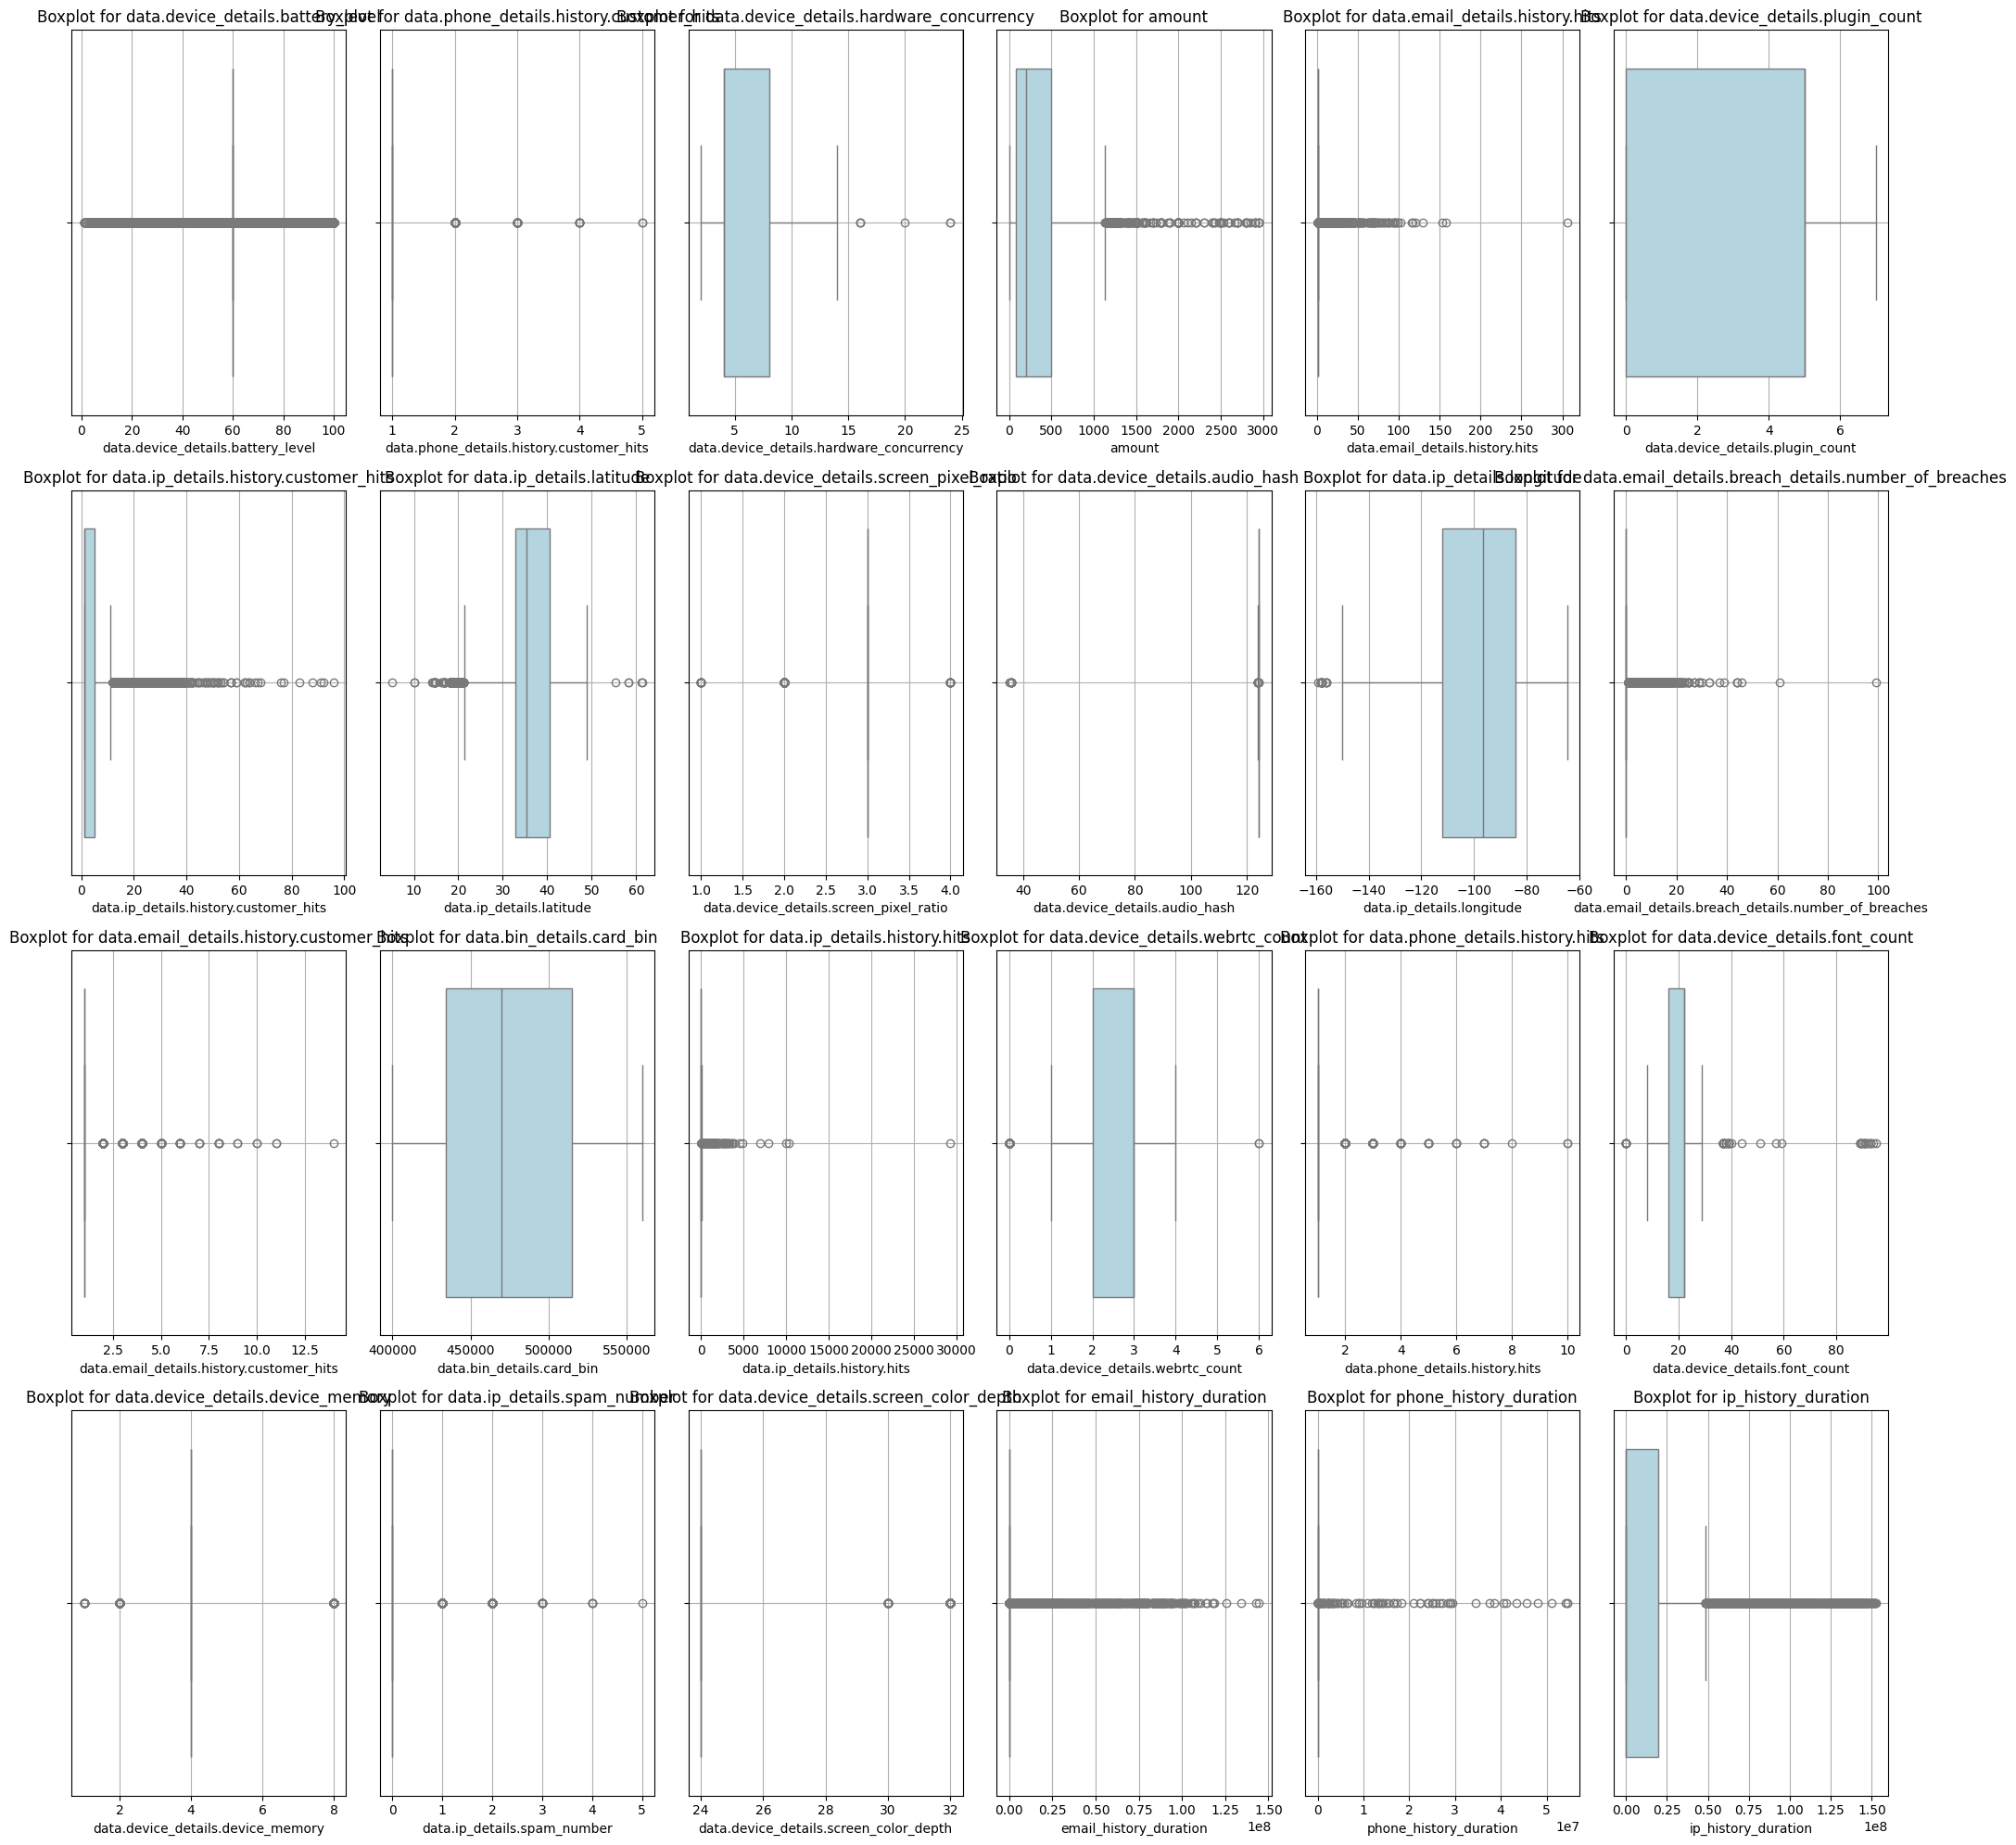

In [ ]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 5 * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each numeric column
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df[column], ax=axes[i], color="lightblue")
    axes[i].set_title(f"Boxplot for {column}")
    axes[i].set_xlabel(column)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

## Normalizing

Many of the numerical features have unusual, highly skewed distributions, so we need to apply preprocessing steps to help normalize or standardize the data for better downstream analysis and modeling.

In [ ]:
log_columns = ['amount', 'data.email_details.history.hits', 'data.ip_details.history.customer_hits', 'data.ip_details.history.hits']
df[log_columns] = df[log_columns].apply(lambda x: np.log1p(x))

Since the unusual distribution leads to outliers significantly affecting scaling, apply MinMaxScaler to scale all features to a [0, 1] range without assuming a Gaussian distribution.

In [ ]:
# Apply MinMaxScaler to numeric columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Boolean Features Cleaning

In [ ]:
bool_columns = df.select_dtypes(include=['bool']).columns

# Print the list of numeric columns
print(f"Number of boolean columns: {len(bool_columns)}")
print("Columns with boolean data types:")
for column in bool_columns:
    print(column)

Number of boolean columns: 27
Columns with boolean data types:
is_disputed
data.email_details.domain_details.disposable
data.device_details.webrtc_activated
data.device_details.flash_enabled
data.ip_details.web_proxy
data.bin_details.bin_valid
data.email_details.domain_details.dmarc_enforced
data.ip_details.vpn
data.ip_details.public_proxy
data.device_details.cookie_enabled
data.phone_details.disposable
__has_error__
data.device_details.adblock
operation_payload.user.new_user_payment
data.email_details.domain_details.suspicious_tld
is_approved
data.email_details.domain_details.free
data.email_details.domain_details.website_exists
data.device_details.java_enabled
data.ip_details.harmful
data.device_details.touch_support
data.email_details.domain_details.custom
phone_details.disposable
data.email_details.domain_details.spf_strict
data.device_details.private
data.email_details.domain_details.registered
data.ip_details.tor


In [ ]:
boolean_features = [
    'data.email_details.domain_details.disposable',
    'data.device_details.webrtc_activated',
    'data.device_details.flash_enabled',
    'data.ip_details.web_proxy',
    'data.bin_details.bin_valid',
    'data.email_details.domain_details.dmarc_enforced',
    'data.ip_details.vpn',
    'data.ip_details.public_proxy',
    'data.device_details.cookie_enabled',
    'data.phone_details.disposable',
    '__has_error__',
    'data.device_details.adblock',
    'operation_payload.user.new_user_payment',
    'data.email_details.domain_details.suspicious_tld',
    'is_approved',
    'data.email_details.domain_details.free',
    'data.email_details.domain_details.website_exists',
    'data.device_details.java_enabled',
    'data.ip_details.harmful',
    'data.device_details.touch_support',
    'data.email_details.domain_details.custom',
    'phone_details.disposable',
    'data.email_details.domain_details.spf_strict',
    'data.device_details.private',
    'data.email_details.domain_details.registered',
    'data.ip_details.tor'
]

# Identify columns that are all True or all False
all_true = []
all_false = []

for feature in boolean_features:
    if df[feature].all():  # Check if all values are True
        all_true.append(feature)
    elif not df[feature].any():  # Check if all values are False
        all_false.append(feature)

# Print the results
print("Features that are all True:")
print(all_true)
print("\nFeatures that are all False:")
print(all_false)

Features that are all True:
['data.bin_details.bin_valid', 'is_approved']

Features that are all False:
['data.device_details.flash_enabled', 'data.ip_details.web_proxy', '__has_error__', 'data.email_details.domain_details.suspicious_tld', 'data.device_details.java_enabled', 'data.ip_details.harmful', 'data.ip_details.tor']


In [ ]:
filtered_boolean_features = [
    feature for feature in boolean_features
    if feature not in all_true and feature not in all_false
]

In [ ]:
# Find pairs of columns that are exactly the same
identical_columns = []
for i in range(len(filtered_boolean_features)):
    for j in range(i + 1, len(filtered_boolean_features)):
        col1, col2 = filtered_boolean_features[i], filtered_boolean_features[j]
        if df[col1].equals(df[col2]):
            identical_columns.append((col1, col2))

# Print the results
print("Pairs of columns that are exactly the same:")
for pair in identical_columns:
    print(pair)

Pairs of columns that are exactly the same:
('data.phone_details.disposable', 'phone_details.disposable')


In [ ]:
df.drop(columns=['phone_details.disposable', 'data.bin_details.bin_valid', 'is_approved',
                 'data.device_details.flash_enabled', 'data.ip_details.web_proxy', '__has_error__',
                 'data.email_details.domain_details.suspicious_tld', 'data.device_details.java_enabled',
                 'data.ip_details.harmful', 'data.ip_details.tor'], errors='ignore', inplace=True)

# Categorical Features Cleaning

## Initial Cleaning (remove redundant)

In [ ]:
object_columns = df.select_dtypes(include=['object']).columns

# Find columns with only two unique values
binary_object_columns = [col for col in object_columns if df[col].nunique() == 2]

# # Print the results
# print("Object columns with only two unique values:")
# for col in binary_object_columns:
#     print(f"{col}: {df[col].unique()}")

In [ ]:
redundant_pairs = []
for i in range(len(object_columns)):
    for j in range(i + 1, len(object_columns)):
        col1, col2 = object_columns[i], object_columns[j]
        if df[col1].equals(df[col2]):  # Check if columns are exactly the same
            redundant_pairs.append((col1, col2))

# # Print the pairs of identical columns
# print("Pairs of identical columns:")
# for pair in redundant_pairs:
#     print(pair)

In [ ]:
redundant_cat = ['data.phone_details.account_details.weibo.registered', 'data.phone_details.account_details.google.registered',
                 'data.bin_details.bin_card', 'data.phone_details.account_details.bukalapak.registered',
                 'data.phone_details.account_details.shopclues.registered', 'data.phone_details.valid',
                 'data.phone_details.account_details.skype.registered', 'data.phone_details.account_details.vkontakte.registered',
                 'data.phone_details.account_details.ok.registered', 'data.phone_details.account_details.altbalaji.registered',
                 'data.phone_details.account_details.snapdeal.registered', 'data.phone_details.account_details.whatsapp.registered',
                 'data.phone_details.account_details.zalo.registered', 'data.phone_details.account_details.microsoft.registered',
                 'data.phone_details.country', 'data.phone_details.account_details.facebook.registered',
                 'data.phone_details.account_details.flipkart.registered', 'data.phone_details.account_details.tiki.registered',
                 'data.phone_details.account_details.twitter.registered', 'data.phone_details.type']
df.drop(columns=redundant_cat, errors='ignore', inplace=True)

df.drop(columns=['data.device_details.font_list',
                 'data.email_details.flags',
                 'data.email_details.account_details.rambler.registered',
                 'data.email_details.account_details.mailru.registered',
                 'data.bin_details.bin_country'], errors='ignore', inplace=True)

Update the variable lists

In [ ]:
object_columns = df.select_dtypes(include=['object']).columns
binary_object_columns = [col for col in object_columns if df[col].nunique() == 2]

registered_columns = [col for col in object_columns if col.endswith(".registered")]

# Create a list for columns starting with 'phone_details'
phone_details_columns = [col for col in registered_columns if col.startswith('phone_details')]

# Create a list for columns starting with 'data.email_details'
email_details_columns = [col for col in registered_columns if col.startswith('data.email_details')]

# # Print the results
# print("Columns starting with 'phone_details':")
# for col in phone_details_columns:
#     print(col)

# print("\nColumns starting with 'data.email_details':")
# for col in email_details_columns:
#     print(col)

## Registration Data

Combine the registration columns into two numerical features:

Feature 1: Total Registered Platforms
* Count the number of platforms a user is registered on. A platform contributes 1 if registered (True), otherwise 0.

Feature 2: Weighted Registration Credibility Score

*   Assign weights to each platform based on its importance (higher weights for bigger/well-known platforms, lower weights for smaller/less popular ones).
*   Compute the weighted sum for each user.

**But the two features are highly correlated (0.97), so we'll just keep one.**

In [ ]:
most_credible = [
    'phone_details.account_details.google.registered',
    'phone_details.account_details.facebook.registered',
    'phone_details.account_details.twitter.registered',
    'phone_details.account_details.microsoft.registered',
    'phone_details.account_details.whatsapp.registered',
    'phone_details.account_details.skype.registered',
    'data.email_details.account_details.google.registered',
    'data.email_details.account_details.microsoft.registered',
    'data.email_details.account_details.amazon.registered',
    'data.email_details.account_details.apple.registered',
    'data.email_details.account_details.netflix.registered',
    'data.email_details.account_details.spotify.registered',
    'data.email_details.account_details.facebook.registered',
    'data.email_details.account_details.twitter.registered',
    'data.email_details.account_details.snapchat.registered',
    'data.email_details.account_details.skype.registered',
]

less_credible = [
    'phone_details.account_details.weibo.registered',
    'data.email_details.account_details.venmo.registered',
    'data.email_details.account_details.yahoo.registered',
    'data.email_details.account_details.quora.registered',
    'data.email_details.account_details.pinterest.registered',
    'data.email_details.account_details.booking.registered',
    'data.email_details.account_details.github.registered',
    'data.email_details.account_details.discord.registered',
    'data.email_details.account_details.codecademy.registered',
    'data.email_details.account_details.duolingo.registered',
    'data.email_details.account_details.vimeo.registered',
    'data.email_details.account_details.bitmoji.registered',
    'data.email_details.account_details.weibo.registered',
    'data.email_details.account_details.disneyplus.registered',
    'data.email_details.account_details.samsung.registered',
    'data.email_details.account_details.adobe.registered',
    'data.email_details.account_details.wordpress.registered',
    'data.email_details.account_details.imgur.registered'
]


not_credible = [
    'phone_details.account_details.vkontakte.registered',
    'phone_details.account_details.bukalapak.registered',
    'phone_details.account_details.shopclues.registered',
    'phone_details.account_details.altbalaji.registered',
    'phone_details.account_details.zalo.registered',
    'phone_details.account_details.ok.registered',
    'phone_details.account_details.flipkart.registered',
    'phone_details.account_details.tiki.registered',
    'phone_details.account_details.snapdeal.registered',
    'data.email_details.account_details.tumblr.registered',
    'data.email_details.account_details.envato.registered',
    'data.email_details.account_details.lazada.registered',
    'data.email_details.account_details.treehouse.registered',
    'data.email_details.account_details.starz.registered',
    'data.email_details.account_details.freelancer.registered',
    'data.email_details.account_details.tokopedia.registered',
    'data.email_details.account_details.zoho.registered',
    'data.email_details.account_details.diigo.registered',
    'data.email_details.account_details.hubspot.registered',
    'data.email_details.account_details.bodybuilding.registered',
    'data.email_details.account_details.giphy.registered',
    'data.email_details.account_details.seoclerks.registered',
    'data.email_details.account_details.myspace.registered',
    'data.email_details.account_details.ok.registered',
    'data.email_details.account_details.flickr.registered',
    'data.email_details.account_details.archiveorg.registered',
    'data.email_details.account_details.rappi.registered',
    'data.email_details.account_details.kommo.registered',
    'data.email_details.account_details.aboutme.registered',
    'data.email_details.account_details.replit.registered',
    'data.email_details.account_details.eventbrite.registered',
    'data.email_details.account_details.patreon.registered',
    'data.email_details.account_details.yandex.registered',
    'data.email_details.account_details.plurk.registered',
    'data.email_details.account_details.qzone.registered',
    'data.email_details.account_details.gravatar.registered',
    'data.email_details.account_details.strava.registered',
    'data.email_details.account_details.komoot.registered',
    'data.email_details.account_details.snapdeal.registered',
    'data.email_details.account_details.altbalaji.registered',
    'data.email_details.account_details.flipkart.registered',
    'data.email_details.account_details.atlassian.registered',
    'data.email_details.account_details.vivino.registered',
    'data.email_details.account_details.adult_sites.registered',
    'data.email_details.account_details.bukalapak.registered',
    'data.email_details.account_details.vkontakte.registered',
    'data.email_details.account_details.deliveroo.registered',
    'data.email_details.account_details.gaana.registered',
    'data.email_details.account_details.wattpad.registered',
    'data.email_details.account_details.xing.registered',
    'data.email_details.account_details.tiki.registered',
]


platform_weights = {}

# Assign weights for most credible platforms
for platform in most_credible:
    platform_weights[platform] = 3

# Assign weights for less credible platforms
for platform in less_credible:
    platform_weights[platform] = 2

# Assign weights for not credible platforms
for platform in not_credible:
    platform_weights[platform] = 1


# Ensure registered_columns are filled with 0 (False) and convert to integer
df[registered_columns] = df[registered_columns].fillna(0).astype(int)

# Compute the registration credibility score
registration_credibility_score = df[registered_columns].dot(pd.Series(platform_weights))

# Use pd.concat to add the new column
df = pd.concat([df, pd.DataFrame({'registration_credibility_score': registration_credibility_score})], axis=1)

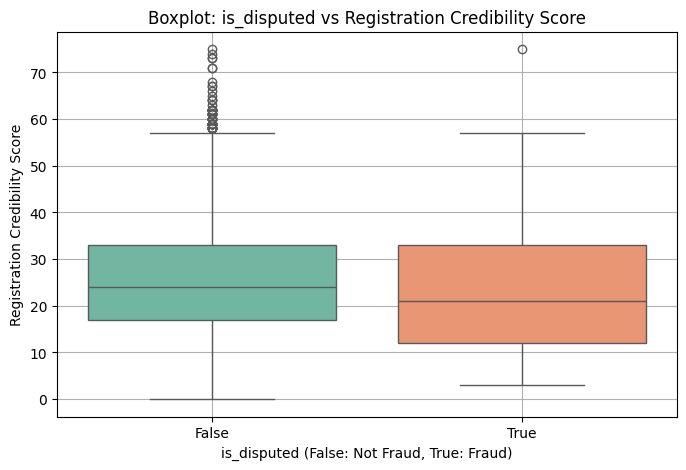

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=df['is_disputed'],
    y=df['registration_credibility_score'],
    hue=df['is_disputed'],
    palette="Set2"
)
plt.title("Boxplot: is_disputed vs Registration Credibility Score")
plt.xlabel("is_disputed (False: Not Fraud, True: Fraud)")
plt.ylabel("Registration Credibility Score")
plt.legend([],[], frameon=False)  # Remove the legend for clarity
plt.grid(True)
plt.show()

In [ ]:
# Apply MinMaxScaler to normalize this column
scaler = MinMaxScaler()

# Apply MinMaxScaler to normalize the 'registration_credibility_score' column
df['registration_credibility_score'] = scaler.fit_transform(
    df[['registration_credibility_score']]
)

In [ ]:
df.drop(columns=registered_columns, errors='ignore', inplace=True)

object_columns = df.select_dtypes(include=['object']).columns
binary_object_columns = [col for col in object_columns if df[col].nunique() == 2]

print(df.shape)
print(len(object_columns))

(15513, 82)
40


In [ ]:
print(object_columns)

Index(['result', 'data.ip_details.type', 'data.device_details.plugin_hash',
       'data.device_details.source', 'data.ip_details.timezone_offset',
       'data.device_details.webgl_vendor',
       'data.device_details.dns_ip_country', 'data.bin_details.card_issuer',
       'operation_status', 'data.email_details.domain_details.accept_all',
       'data.email_details.domain_details.tld',
       'data.device_details.region_timezone', 'data.email_details.deliverable',
       'data.device_details.os', 'data.bin_details.bin_type',
       'phone_details.country', 'data.ip_details.country',
       'data.device_details.device_ip_country', 'phone_details.valid',
       'data.ip_details.state_prov',
       'data.email_details.domain_details.registrar_name',
       'data.ip_details.spam_urls',
       'data.email_details.domain_details.valid_mx', 'steps',
       'data.email_details.domain_details.registered_to', 'avs_check',
       'cvv_check', 'data.device_details.browser',
       'data.bin_deta

## List of categorical features to analyze

In [ ]:
onehot_cat = [
    'data.bin_details.bin_type',
    'data.email_details.domain_details.accept_all',
    'data.email_details.deliverable',
    'data.email_details.domain_details.valid_mx',
    'data.email_details.breach_details.haveibeenpwned_listed',
    'data.device_details.battery_charging',
    'steps',
    'data.bin_details.card_issuer',
    'operation_status',
    'data.ip_details.type'
]

country_features = [
    'data.device_details.device_ip_country',
    'data.device_details.dns_ip_country',
    'data.ip_details.country',
    'phone_details.country',
    'data.bin_details.bin_country_code'
]

# for col in columns_to_plot:
#     print(f"{col}: {df[col].unique()}")

weird_features = [
    'data.device_details.webgl_vendor',
    'data.device_details.plugin_hash',
    'data.email_details.domain_details.registrar_name',
    'data.ip_details.spam_urls',
    'data.email_details.domain_details.registered_to',
    'data.device_details.font_hash',
    'data.device_details.plugin_list'
]

# for feature in weird_features:
#     if feature in df.columns:  # Ensure the feature exists in the DataFrame
#         plt.figure(figsize=(10, 5))
#         sns.countplot(data=df, x=feature, hue='is_disputed', palette="Set2")
#         plt.title(f"Distribution of is_disputed by {feature}")
#         plt.xlabel(feature)
#         plt.ylabel("Count")
#         plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
#         plt.legend(title="is_disputed", loc="upper right")
#         plt.tight_layout()
#         plt.show()
#     else:
#         print(f"Feature '{feature}' not found in the DataFrame.")

## Encoding

Frequency encoding replaces categories with their frequency of occurrence. Both tree-based models (Random Forest, XGBoost) and Logistic Regression can handle this well.
It captures the importance of categories based on their prevalence but does not consider the relationship with the target.

When to Use: if features have many unique categories (high cardinality).

In [ ]:
# One-hot encode country features
valid_countries = ['US', 'MX', 'PR']

# Impute NaN with 'Unknown' and group into categories
for feature in country_features:
    df[feature] = df[feature].fillna('Unknown')  # Impute NaN with 'Unknown'
    df[feature] = df[feature].apply(
        lambda x: x if x in valid_countries else 'Other'
    )

# One-hot encode the grouped categories
df = pd.get_dummies(df, columns=country_features, prefix=country_features, drop_first=False)

In [ ]:
# Apply one-hot encoding to the binary features
df[onehot_cat] = df[onehot_cat].fillna('Unknown')

# Apply one-hot encoding to the specified columns
df = pd.get_dummies(df, columns=onehot_cat, prefix=onehot_cat, drop_first=False)

In [ ]:
# Apply Frequency Encoding to the rest of categorical features
freq_cat = set(object_columns) - set(onehot_cat) - set(country_features) - {'result'}

for feature in freq_cat:
    df[feature] = df[feature].fillna('Unknown')  # Impute NaN with 'Unknown'
    freq_encoding = df[feature].value_counts(normalize=True)
    df[feature] = df[feature].map(freq_encoding)

In [ ]:
df.drop(columns='result', errors='ignore', inplace=True)

In [ ]:
print(df.shape)

(15513, 118)


In [ ]:
df.to_csv("/content/drive/MyDrive/encoded_data.csv", index=False)

# Class Imbalance

In [ ]:
# Check for columns with NaN values
nan_columns = df.isnull().sum()

# Filter only columns with NaN values
nan_columns = nan_columns[nan_columns > 0]

# Output the results
if not nan_columns.empty:
    print("Columns with NaN values and their counts:")
    print(nan_columns)
else:
    print("No columns contain NaN values.")

No columns contain NaN values.


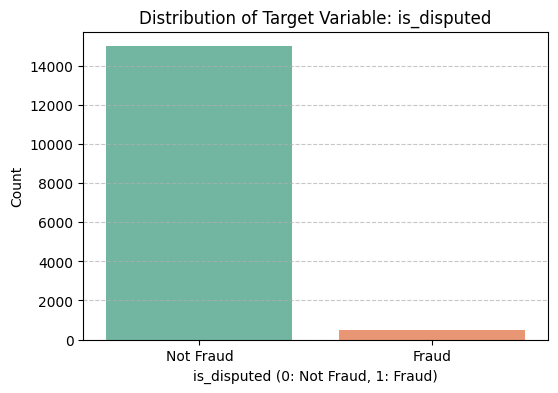

In [ ]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_disputed', hue='is_disputed', palette='Set2', dodge=False, legend=False)
plt.title("Distribution of Target Variable: is_disputed")
plt.xlabel("is_disputed (0: Not Fraud, 1: Fraud)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Not Fraud", "Fraud"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Separate features (X) and target (y)
X = df.drop(columns=['is_disputed'])
y = df['is_disputed']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display results
print("Original class distribution in training set:")
print(y_train.value_counts())

print("\nResampled class distribution in training set:")
print(pd.Series(y_train_resampled).value_counts())

Original class distribution in training set:
is_disputed
False    12000
True       410
Name: count, dtype: int64

Resampled class distribution in training set:
is_disputed
False    12000
True     12000
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
logistic_model = LogisticRegression()


logistic_model.fit(X_train, y_train)
# Predict on the test set
Y_pred = logistic_model.predict(X_test)


# XGBoost

In [ ]:
df.head()

In [ ]:
# PCA
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_train)

# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X_train_resampled)

# print("Original shape:", X_train.shape)
# print("Reduced shape:", X_pca.shape)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca_final = PCA(n_components=40)

# Fit PCA on the dataset
pca_final.fit(X_train_resampled)

# The components_ attribute contains the loadings for each principal component (rows) for each feature (columns)
loadings = pca_final.components_.T

# Create a DataFrame with the loadings and the names of the original features
features = X_train_resampled.columns
loadings_df = pd.DataFrame(loadings, index=features, columns=[f'PC{i+1}' for i in range(40)])

# Now we can understand each principal component's relationship with the original features
loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
data.device_details.battery_level,0.015423,-0.011186,0.002926,0.028673,0.000875,0.011542,0.028918,0.070318,-0.071048,-0.037459,...,0.644232,-0.469775,0.136747,-0.009383,-0.027073,0.005765,0.025175,-0.060622,0.009359,-0.061449
data.phone_details.history.customer_hits,-0.009457,-0.009711,-0.003660,0.009501,-0.008100,-0.003890,0.006382,-0.012600,0.014833,0.002067,...,0.020449,-0.008118,-0.003017,-0.009296,0.009156,-0.007237,0.009337,0.048369,-0.011275,-0.022281
data.device_details.plugin_hash,0.031513,0.005160,0.002539,0.008491,-0.012243,-0.020896,-0.026636,-0.062871,0.045796,0.057795,...,0.025324,-0.030861,0.023486,-0.001867,-0.014775,0.012638,0.010140,-0.029458,-0.018273,-0.016617
data.email_details.domain_details.disposable,0.005754,-0.020453,0.011600,-0.004999,-0.000919,0.002565,-0.006748,0.004698,-0.004145,0.023525,...,0.004831,-0.033023,0.130467,-0.037417,0.023186,-0.044852,-0.028807,0.021979,-0.108600,0.112459
data.device_details.webrtc_activated,-0.004469,-0.009613,0.004874,-0.001056,0.009861,-0.002498,-0.006839,0.004958,0.002366,0.014013,...,0.015067,-0.043471,0.027197,0.017454,0.114987,-0.007425,0.070962,0.011540,0.033780,0.020649


In [ ]:
# Calculate the number of features to select (20% of the features)
num_features = int(len(loadings_df) * 0.3)

# Find features with the highest loadings in absolute terms across all components
important_features = set()
for column in loadings_df.columns:
    # Sort features based on the absolute loadings for each component and take the top 'num_features'
    important_features = loadings_df[column].abs().sort_values(ascending=False).head(num_features).index

print(f"{len(important_features)} important features selected based on PCA loadings:")
print(important_features)

35 important features selected based on PCA loadings:
Index(['data.bin_details.card_issuer_VISA',
       'data.bin_details.card_issuer_MASTERCARD', 'amount',
       'data.bin_details.card_bin', 'data.email_details.deliverable_True',
       'data.bin_details.bin_level', 'registration_credibility_score',
       'data.email_details.deliverable_False',
       'data.email_details.domain_details.registrar_name',
       'data.email_details.domain_details.custom',
       'data.email_details.domain_details.accept_all_Unknown',
       'data.email_details.domain_details.disposable',
       'phone_details.country_MX', 'steps_['SEON', 'RISKIFIED']',
       'data.device_details.dns_ip_country_US',
       'data.email_details.domain_details.accept_all_False',
       'phone_details.country_Other', 'data.device_details.adblock',
       'data.device_details.source',
       'data.email_details.domain_details.spf_strict',
       'data.device_details.battery_charging_True',
       'data.email_details.domain

In [ ]:
# Select only the important features for both training and testing set
X_train_important = X_train_resampled[list(important_features)]
X_test_important = X_test[list(important_features)]

In [ ]:
# 80-20 train-test split
from sklearn.model_selection import train_test_split


Training set shape: (12410, 117)
Test set shape: (3103, 117)


In [ ]:
X_train = X_train_important.copy()
X_test = X_test_important.copy()

X_train.columns = X_train.columns.str.replace('[\[\]<]', '', regex=True)  # Remove invalid characters
X_test.columns = X_test.columns.str.replace('[\[\]<]', '', regex=True)

In [ ]:
# training XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

xgboost_model = XGBClassifier(random_state=42, scale_pos_weight= len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.970995810505962
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.99      3000
        True       0.59      0.41      0.48       103

    accuracy                           0.97      3103
   macro avg       0.79      0.70      0.73      3103
weighted avg       0.97      0.97      0.97      3103

Confusion Matrix:
 [[2971   29]
 [  61   42]]
ROC AUC Score: 0.6990501618122977


In [ ]:
# oversampling using the SMOTE algorithm
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution in training set:")
print(y_train.value_counts())

print("\nResampled class distribution in training set:")
print(pd.Series(y_train_resampled).value_counts())

Original class distribution in training set:
is_disputed
False    12000
True       410
Name: count, dtype: int64

Resampled class distribution in training set:
is_disputed
False    12000
True     12000
Name: count, dtype: int64


In [ ]:
# training XGBoost with oversampling
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

xgboost_model = XGBClassifier(random_state=42)
xgboost_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.9722848855945859
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.99      3000
        True       0.68      0.31      0.43       103

    accuracy                           0.97      3103
   macro avg       0.83      0.65      0.71      3103
weighted avg       0.97      0.97      0.97      3103

Confusion Matrix:
 [[2985   15]
 [  71   32]]
ROC AUC Score: 0.6528398058252427


In [ ]:
# finding feature importance
feature_importances = xgboost_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame with feature names and importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the top 10 features
print(feature_importances_df.head(3))

                                        Feature  Importance
4          data.device_details.webrtc_activated    0.063384
66  data.device_details.device_ip_country_Other    0.062162
16          data.device_details.region_timezone    0.058517


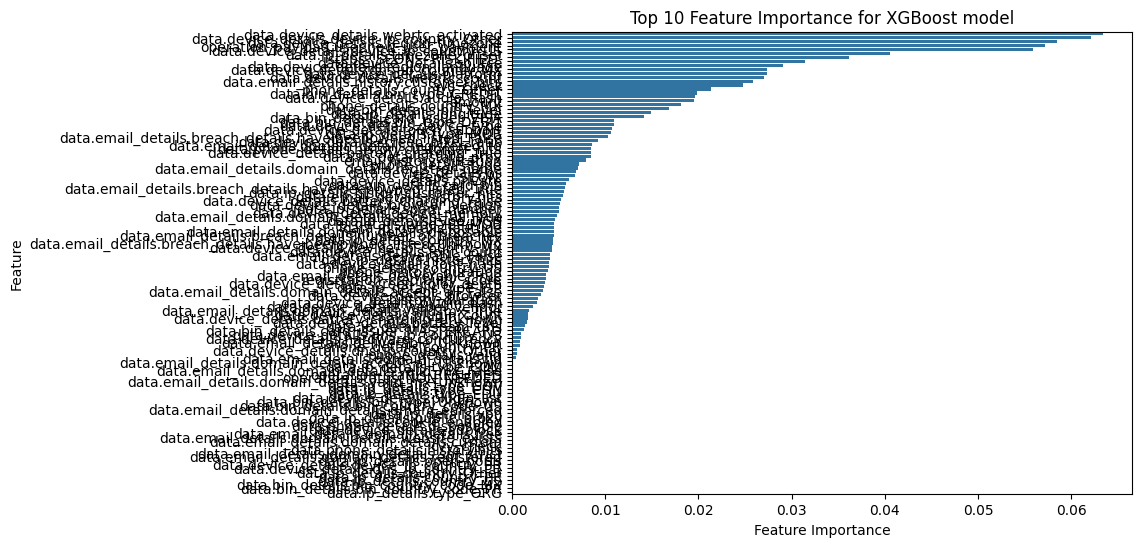

In [ ]:
# visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance for XGBoost model')
plt.show()

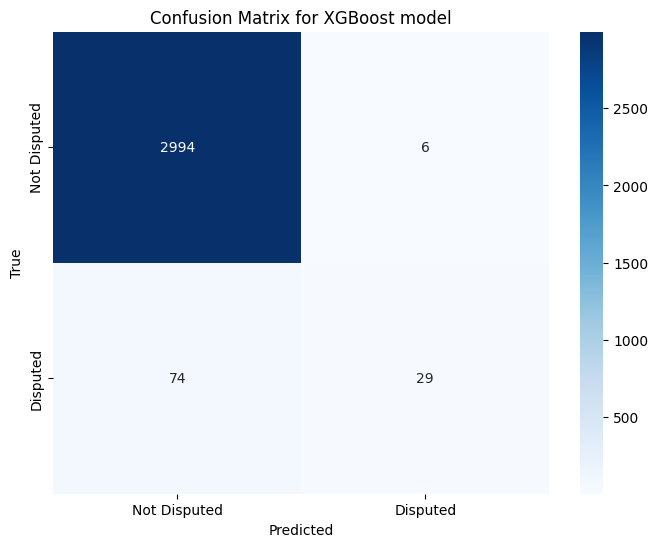

In [ ]:
# visualize the confusion matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# change 0 in the column name to Not disputed, 1 to Disputed
cm = pd.DataFrame(cm, index=['Not Disputed', 'Disputed'], columns=['Not Disputed', 'Disputed'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost model')
plt.show()


In [ ]:
# @title optimizing threshold
from sklearn.metrics import precision_recall_curve

y_prob = xgboost_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

In [ ]:
print("Best Threshold:", best_threshold)

Best Threshold: 0.33026782


In [ ]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Best Score: 0.9735696495605773


In [ ]:
# model evaluation
y_pred = grid_search.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.9742184982275217
Classification Report:
               precision    recall  f1-score   support

       False       0.98      1.00      0.99      3000
        True       0.83      0.28      0.42       103

    accuracy                           0.97      3103
   macro avg       0.90      0.64      0.70      3103
weighted avg       0.97      0.97      0.97      3103

Confusion Matrix:
 [[2994    6]
 [  74   29]]
ROC AUC Score: 0.6397766990291262


### Insights
Accuracy: 98.52%
- The model correctly classified 98.52% of the transactions as either disputed or not disputed. This is a very high accuracy, indicating strong overall performance.

Classification:
- Precision: true positive predictions among all positive predictions
  - False (Not Disputed): 0.99 ---99% of transactions predicted as "Not Disputed" were correct.
  - True (Disputed): 0.98---98% of transactions predicted as "Disputed" were correct.
- Recall: The proportion of true positive cases detected among all actual positives.
  - False (Not Disputed): 0.98
  
    The model captured 98% of the actual "Not Disputed" transactions.
  - True (Disputed): 0.99

    The model captured 99% of the actual "Disputed" transactions.
- F1-Score: The harmonic mean of precision and recall, providing a balance between the two.
Both classes (False and True) have F1-scores of 0.99, showing balanced performance across the two categories.


Confusion matrix


# Others


## NUMERICAL VISUALIZATION

In [ ]:
# make a bar chart of each numerical column
for col in df_num.columns:
  plt.bar(df_num[col].value_counts().index, df_num[col].value_counts().values)
  plt.title(col)
  plt.show()

From the bar charts for numerical data, there are some interesting things to plot and explore more.

In [ ]:
fraud_df = pd.read_csv("/content/drive/MyDrive/UPenn/ECAs/WUDAC/distribution_of_fraud_scores.csv")

In [ ]:
fraud_df.head()

## is_fraud explortion
the 'result' column is the column that shows whether the transaction is approved or declined

In [ ]:
# find the fraud column
df.filter(regex = "fraud").columns

In [ ]:
df.result.value_counts()

In [ ]:
df_cat.columns.to_list()

## Plot exploration
- latitude-longtitude
- data.email_details.breach_details.number_of_breaches vs amount

In [ ]:
# plot data.email_details.breach_details.number_of_breaches vs amount,
# separating in color by the 'result' column
'''
assumption: the more breaches, the more likely it is to be a fraud
- ineresting data: data on the right side of the graph
'''
plt.scatter(df[df["result"] == "APPROVE"]["data.email_details.breach_details.number_of_breaches"], df[df["result"] == "APPROVE"]["amount"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.email_details.breach_details.number_of_breaches"], df[df["result"] == "DECLINE"]["amount"], color = "red", label = "declined")
plt.xlabel("number of email breaches")
plt.ylabel("amount")
plt.title("number of email breaches vs amount per transaction")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# for data with more than 10 email breaches, what is the history.customer_hits
# separating in color by the 'result' column
plt.scatter(df[df["result"] == "APPROVE"]["data.email_details.history.customer_hits"], df[df["result"] == "APPROVE"]["amount"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.email_details.history.customer_hits"], df[df["result"] == "DECLINE"]["amount"], color = "red", label = "declined")
plt.xlabel("email customer hits")
plt.ylabel("amount")
plt.title("email customer hits vs amount per transaction")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# **`data.ip_details.history.customer_hits`** vs **`amount`**
# separate based on 'result' column
plt.scatter(df[df["result"] == "APPROVE"]["data.ip_details.history.customer_hits"], df[df["result"] == "APPROVE"]["amount"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.ip_details.history.customer_hits"], df[df["result"] == "DECLINE"]["amount"], color = "red", label = "declined")
plt.xlabel("customer hits")
plt.ylabel("amount")
plt.title("ip details customer hits vs amount per transaction")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# data.device_details.webrtc_count vs amount
plt.scatter(df["data.device_details.webrtc_count"], df["amount"])
plt.xlabel("webrtc count")
plt.ylabel("amount")
plt.title("webrtc count vs amount")
plt.grid(True)
plt.show()

In [ ]:
# data.phone_details.history.hits vs amount
plt.scatter(df["data.phone_details.history.hits"], df["amount"])
plt.xlabel("phone hits")
plt.ylabel("amount")
plt.title("phone hits vs amount")
plt.grid(True)
plt.show()

In [ ]:
# phone_details.history.customer_hits vs amount
plt.scatter(df["data.phone_details.history.customer_hits"], df["amount"])
plt.xlabel("customer hits")
plt.ylabel("amount")
plt.title("phone history customer hits vs amount")
plt.grid(True)
plt.show()

In [ ]:
# plot phone_details.history.customer_hits vs data.email_details.history.customer_hits
plt.scatter(df["data.phone_details.history.customer_hits"], df["data.email_details.history.customer_hits"])
plt.xlabel("phone customer hits")
plt.ylabel("email customer hits")
plt.title("phone customer hits vs email customer hits")
plt.grid(True)
plt.show()

In [ ]:
# plotting between latitude and longitude
# separate using 'result'
plt.scatter(df[df["result"] == "APPROVE"]["data.ip_details.longitude"], df[df["result"] == "APPROVE"]["data.ip_details.latitude"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.ip_details.longitude"], df[df["result"] == "DECLINE"]["data.ip_details.latitude"], color = "red", label = "declined")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("location")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# email customer hits vs phone customer hits
plt, ax = plt.subplots()
ax.scatter(df["data.email_details.history.customer_hits"], df["data.phone_details.history.customer_hits"], )
ax.set_xlabel("email customer hits")
ax.set_ylabel("phone customer hits")


In [ ]:
# email hits vs amount
plt.scatter(df["data.email_details.history.customer_hits"], df["amount"])
plt.xlabel("email hits")
plt.ylabel("amount")
plt.title("email hits vs amount")
plt.grid(True)
plt.show

In [ ]:
# number of email breaches vs email customer hits
# separate by result

plt.scatter(df[df["result"] == "APPROVE"]["data.email_details.breach_details.number_of_breaches"], df[df["result"] == "APPROVE"]["data.email_details.history.customer_hits"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.email_details.breach_details.number_of_breaches"], df[df["result"] == "DECLINE"]["data.email_details.history.customer_hits"], color = "red", label = "declined")
plt.xlabel("number of email breaches")
plt.ylabel("email customer hits")
plt.title("number of email breaches vs email customer hits")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# number of email customer hits vs amount
# separate by result
plt.scatter(df[df["result"] == "APPROVE"]["data.email_details.history.customer_hits"], df[df["result"]
== "APPROVE"]["amount"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.email_details.history.customer_hits"], df[df["result"]
== "DECLINE"]["amount"], color = "red", label = "declined")
plt.xlabel("number of email customer hits")
plt.ylabel("amount")
plt.title("number of email customer hits vs amount")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# phone customer hits vs amount
# separate by result
plt.scatter(df[df["result"] == "APPROVE"]["data.phone_details.history.customer_hits"], df[df["result"]
== "APPROVE"]["amount"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.phone_details.history.customer_hits"], df[df["result"]
== "DECLINE"]["amount"], color = "red", label = "declined")
plt.xlabel("phone customer hits")
plt.ylabel("amount")
plt.title("phone customer hits vs amount")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# data IP details spam vs amount
# separate by result
plt.scatter(df[df["result"] == "APPROVE"]["data.ip_details.spam_number"], df[df["result"]
== "APPROVE"]["amount"], color = "blue", label = "approved")
plt.scatter(df[df["result"] == "DECLINE"]["data.ip_details.spam_number"], df[df["result"]
== "DECLINE"]["amount"], color = "red", label = "declined")
plt.xlabel("spam number")
plt.ylabel("amount")
plt.title("spam number vs amount")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# data IP details spam vs amount
# separate by result into bar separate bars chart percentage
# for spam number > 0
x = np.arange(len(df[df["result"] == "APPROVE"]["data.ip_details.spam_number"] > 0))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df[df["result"] == "APPROVE"]["amount"], width, label = "approved")
rects2 = ax.bar(x + width/2, df[df["result"] == "DECLINE"]["amount"], width, label = "declined")

ax.set_ylabel("amount")
ax.set_title("spam number vs amount")
ax.set_xticks(x)
ax.set_xticklabels(df[df["result"] == "APPROVE"]["data.ip_details.spam_number"] > 0)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


In [ ]:
# IP spam number vs phone customer hits
# plot a bubble with size based on number of occurrences
fig, ax = plt.subplots()
scatter = ax.scatter(df["data.ip_details.spam_number"], df["data.phone_details.history.customer_hits"], s=df["amount"], alpha=0.5)
ax.set_xlabel('IP spam number')
ax.set_ylabel('phone customer hits')
ax.set_title('IP spam number vs phone customer hits')


# Others


# Data exploration: apps
explore what's in the transaction data

# data exploration
for each data, find the ratio of registration by phone and by email

In [ ]:
# find 'registered' columns
df.filter(regex = "registered").columns

In [ ]:
# for each app, find the percentage registered users and create a dataframe
df_registered = pd.DataFrame()
for app in df.filter(regex = "registered").columns:
    df_registered[app] = df[app].value_counts(normalize = True)

df_registered = df_registered.T

In [ ]:
df_registered.rename(columns = {0: "not_registered", 1: "registered"}, inplace = True)


In [ ]:
df_registered.sort_values(by = "registered", ascending = False, inplace = True)

In [ ]:
# drop the app with NaN registered
df_registered.dropna(inplace = True)

In [ ]:
# create a table with email registered
df_registered_email = df_registered[df_registered.index.str.contains("email")]

In [ ]:
df_registered_email

In [ ]:
df_registered_phone = df_registered[df_registered.index.str.contains("phone")]

In [ ]:
df_registered_phone

In [ ]:
# drop rows that start with phone_details
df_registered_phone.drop(index = df_registered_phone[df_registered_phone.index.str.startswith("phone_details")].index, inplace = True)

In [ ]:
df_registered_phone

In [ ]:
# find instagram in registered email
df_registered_email[df_registered_email.index.str.contains("instagram")]

## Insights
Top apps that people register by phone:
1. WhatsApp
2. Facebook
3. Google
4. Instagram
5. Twitter

Top apps that people register by email:
1. domain_details (email?)
2. Google
3. Spotify
4. Amazon
5. Facebook

### Search more actions on the top apps after user registration
- what's their last whatsapp access?
- what's their last google access?
- what's their last FB access?

In [ ]:
# create a df containing of every column related to whatsapp
df_whatsapp = df[df.filter(regex = "whatsapp").columns]

# change columns with name containing 'phone_details' to str
regex = "phone_details"
df_whatsapp.columns = df_whatsapp.columns.str.replace(regex, "phone_details", regex = True)

In [ ]:
# count the NaN values of last seen
df_whatsapp["data.phone_details.account_details.whatsapp.last_seen"].isnull().sum()

In [ ]:
df_whatsapp

## Insights
- 15348 NaN

# Data exploration: non-apps/registration column

In [ ]:
# import duckDB
import duckdb

# connect to duckDB
con = duckdb.connect(database = ":memory:")

In [ ]:
# using duckDB
# use df in duckDB
con.execute("CREATE TABLE df AS SELECT * FROM df")



In [ ]:
# select columns without 'registration'
query = '''
SELECT * from df
WHERE
'''

df_test = con.execute(query).fetchdf()


In [ ]:
df_test